# TIME Foundations I

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL

from utils import get_figure, time_plot, moving_average_smoothing
from data import get_electrocardiogram, get_switzerland_temperature, get_mauna_loa_co2, get_random_walk

## Realization of a stochastic process

0   -0.245
1   -0.215
2   -0.185
3   -0.175
4   -0.170
5   -0.170
6   -0.185
7   -0.170
8   -0.160
9   -0.150
Name: ecg, dtype: float64


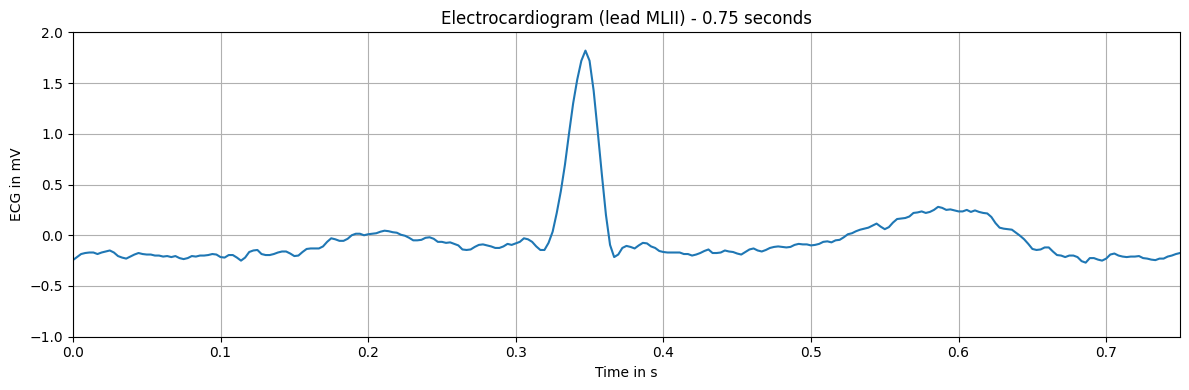

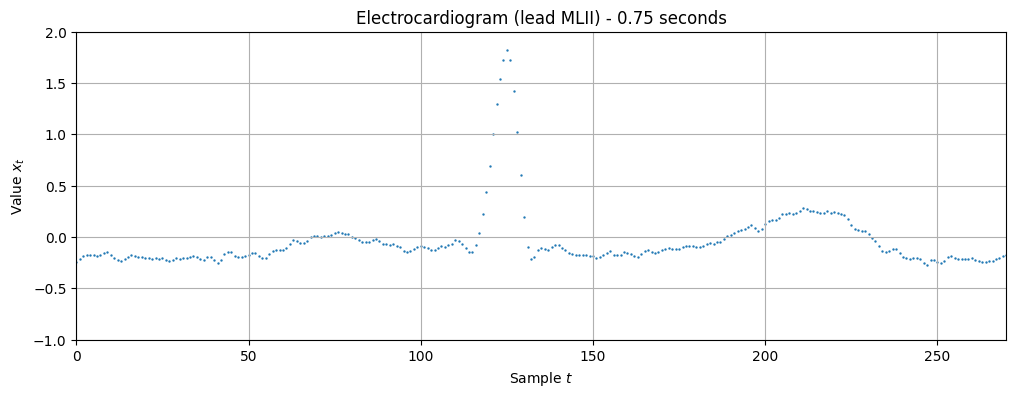

In [2]:
data = get_electrocardiogram()
time_plot(
    x=data['time'],
    y=data['ecg'],
    title='Electrocardiogram (lead MLII) - 0.75 seconds',
    xlabel='Time in s',
    ylabel='ECG in mV',
    xlim=(0,.75),
    ylim=(-1,2),
)

fig, [ax] = get_figure()
ax.scatter(data.index, data['ecg'], s=.5)
ax.set_xlabel('Sample $t$')
ax.set_ylabel('Value $x_t$')
ax.set_title("Electrocardiogram (lead MLII) - 0.75 seconds")
ax.set_xlim(0, .75*360)
ax.set_ylim(-1, 2)
print(data['ecg'].iloc[:10])

## Probability concepts

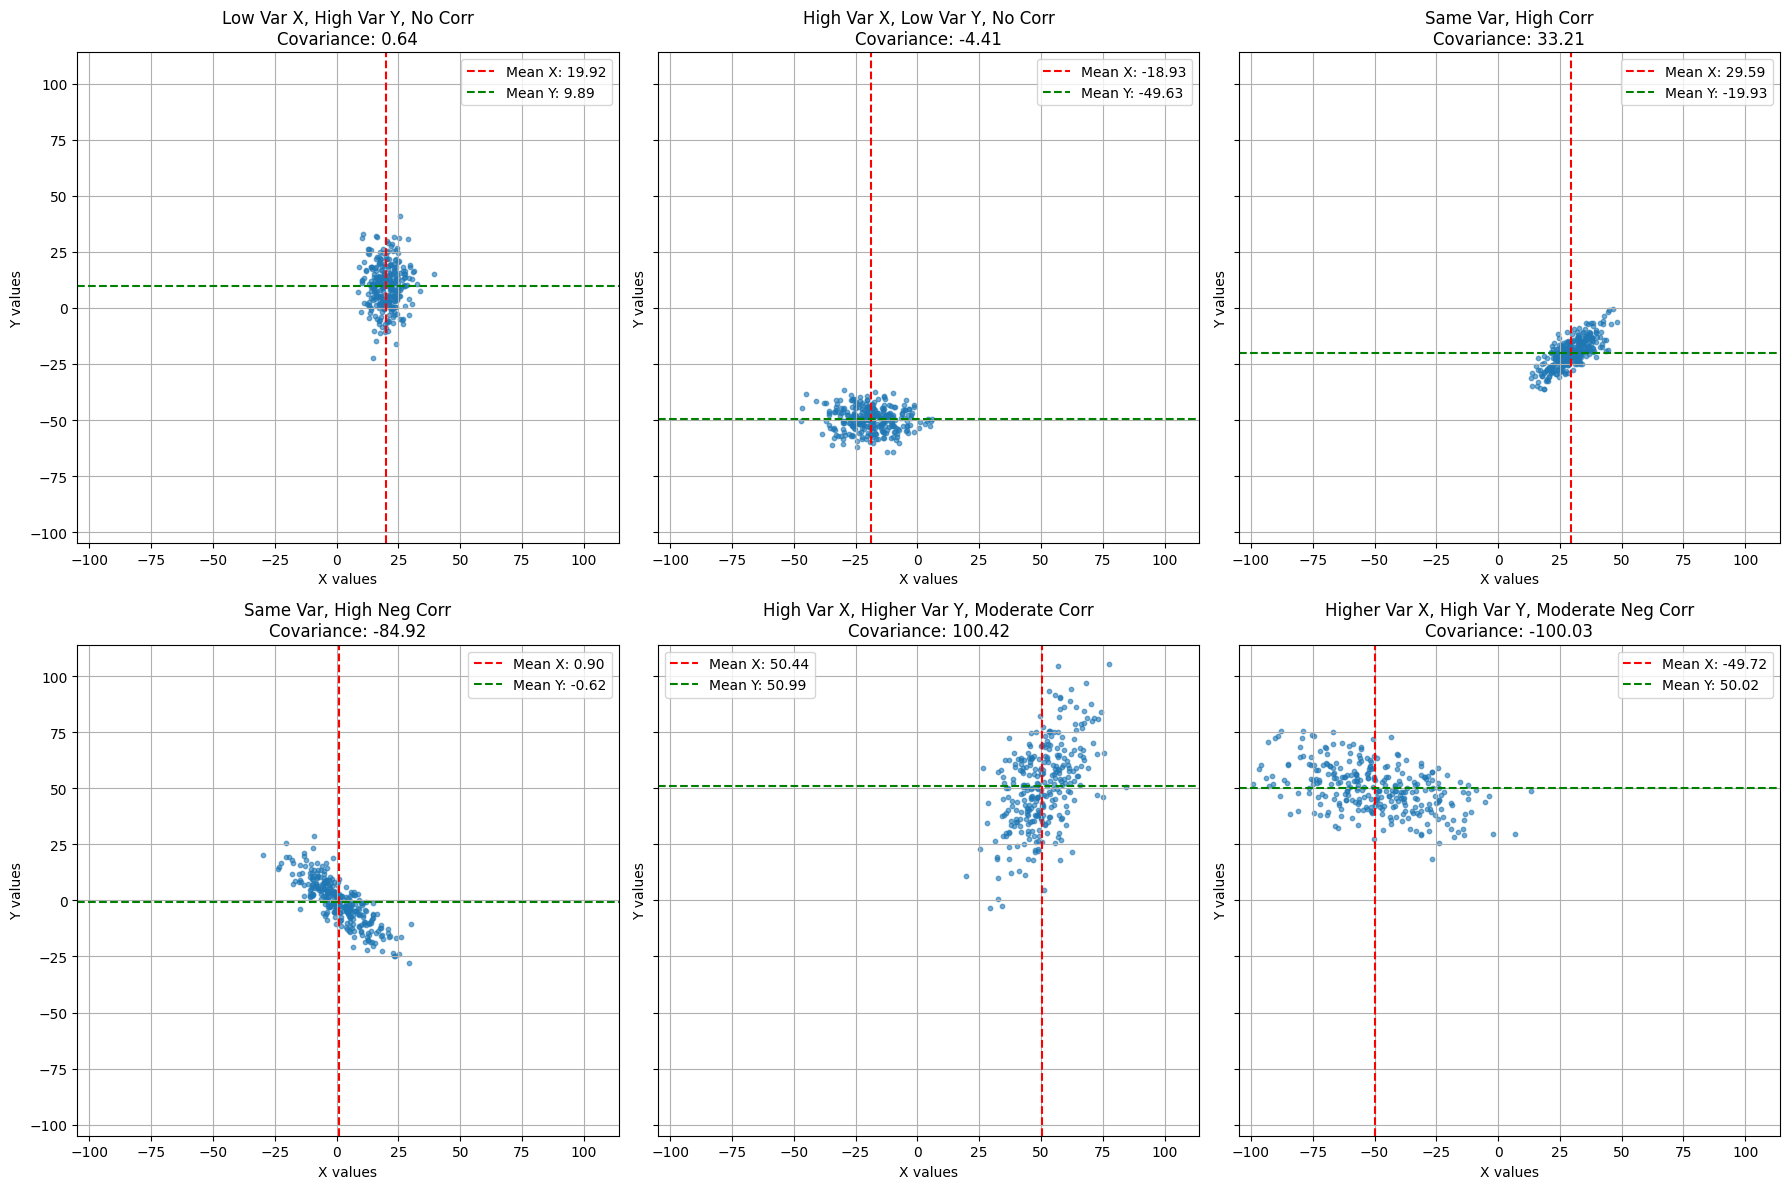

In [3]:
def generate_data(mean_X: float, mean_Y: float, var_X: float, var_Y: float, rho: float) -> tuple[np.ndarray, np.ndarray]:
    cov_XY = rho * np.sqrt(var_X * var_Y)
    mean = [mean_X, mean_Y]
    cov = [[var_X, cov_XY], [cov_XY, var_Y]]
    XY_data = np.random.multivariate_normal(mean, cov, 300)
    return XY_data[:, 0], XY_data[:, 1]

scenarios = [
    (20, 10, 25, 100, 0),    # Different variance, no correlation
    (-20, -50, 100, 25, 0),    # Different variance, no correlation, swapped
    (30, -20, 50, 50, 0.8),  # Same variance, high correlation
    (0, 0, 100, 100, -0.8),  # Same variance, high negative correlation
    (50, 50, 100, 400, 0.5), # Different variance, moderate correlation
    (-50, 50, 400, 100, -0.5) # Different variance, moderate negative correlation
]

titles = [
    "Low Var X, High Var Y, No Corr",
    "High Var X, Low Var Y, No Corr",
    "Same Var, High Corr",
    "Same Var, High Neg Corr",
    "High Var X, Higher Var Y, Moderate Corr",
    "Higher Var X, High Var Y, Moderate Neg Corr"
]

fig, axs = get_figure(nrows=2, ncols=3, figsize=(18, 12), sharey=True)
np.random.seed(42)
for ax, (mean_X, mean_Y, var_X, var_Y, rho), title in zip(axs, scenarios, titles):
    X, Y = generate_data(mean_X, mean_Y, var_X, var_Y, rho)
    covariance = np.cov(X, Y)[0, 1]
    ax.scatter(X, Y, alpha=0.6, s=10)
    ax.axvline(x=np.mean(X), color='r', linestyle='--', label=f'Mean X: {np.mean(X):.2f}')
    ax.axhline(y=np.mean(Y), color='g', linestyle='--', label=f'Mean Y: {np.mean(Y):.2f}')
    ax.set_title(f"{title}\nCovariance: {covariance:.2f}")
    ax.set_xlabel('X values')
    ax.set_ylabel('Y values')
    ax.legend()

xlims = [min(ax.get_xlim()[0] for ax in axs), max(ax.get_xlim()[1] for ax in axs)]
ylims = [min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)]
lim = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
for ax in axs:
    ax.set_xlim(lim)
    ax.set_ylim(lim)
fig.tight_layout()

### Normal distribution

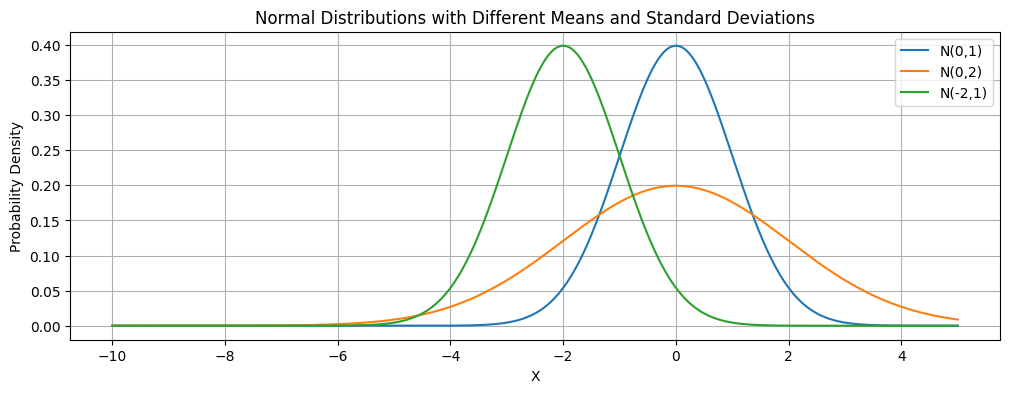

In [4]:
fig, [ax] = get_figure()
parameters = [(0, 1), (0, 2), (-2, 1)]  # (mean, standard deviation)
x = np.linspace(-10, 5, 1000)
for mu, sigma in parameters:
    y = (1 / (np.sqrt(2 * np.pi * sigma**2))) * np.exp(- (x - mu)**2 / (2 * sigma**2))
    plt.plot(x, y, label=f'N({mu},{sigma})')
ax.set_title('Normal Distributions with Different Means and Standard Deviations')
ax.set_xlabel('X')
ax.set_ylabel('Probability Density')
ax.legend()

### Autocorrelation

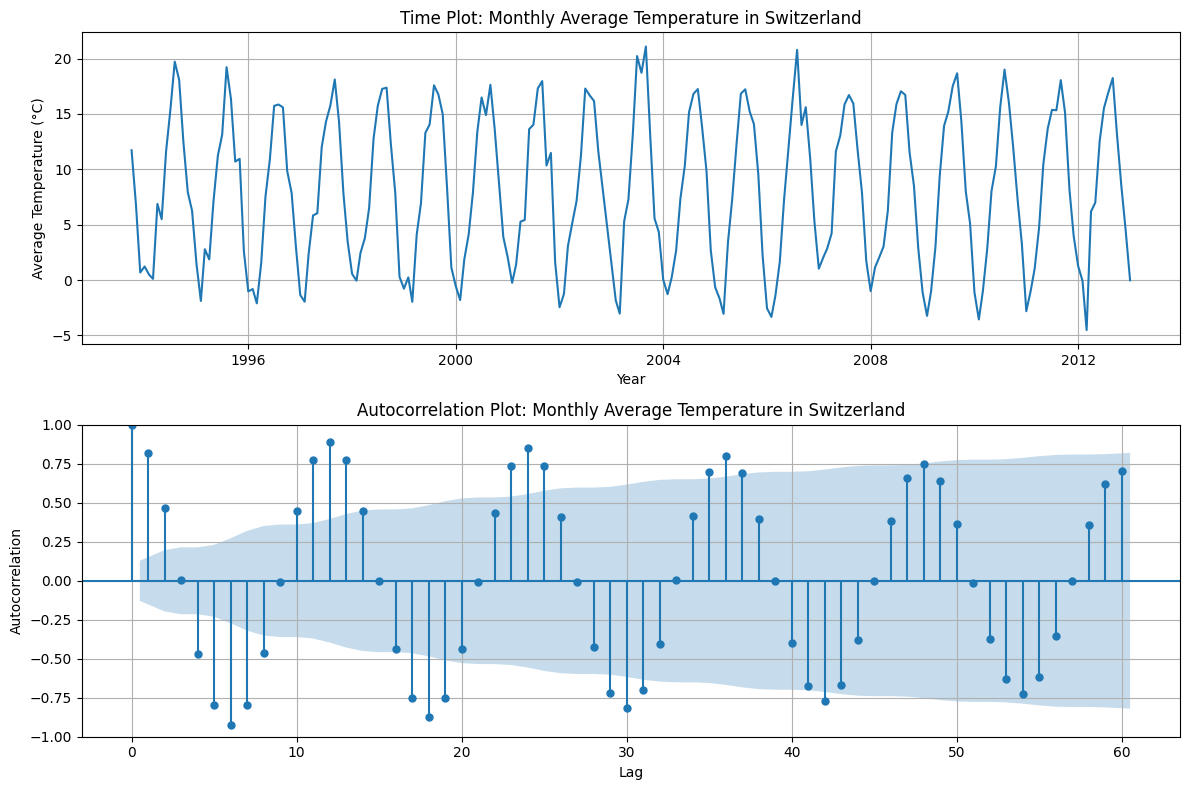

In [5]:
data = get_switzerland_temperature()
fig, (ax1, ax2) = get_figure(nrows=2, ncols=1, figsize=(12, 8))
time_plot(
    x=data['dt'],
    y=data['AverageTemperature'],
    title=f'Time Plot: Monthly Average Temperature in Switzerland',
    xlabel='Year',
    ylabel='Average Temperature (°C)',
    ax=ax1,
)
sm.graphics.tsa.plot_acf(data['AverageTemperature'], lags=60, ax=ax2)
ax2.set_title(f'Autocorrelation Plot: Monthly Average Temperature in Switzerland', y=1)
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocorrelation')
ax2.grid(True)
fig.tight_layout()

## Stochastic process examples

### White noise

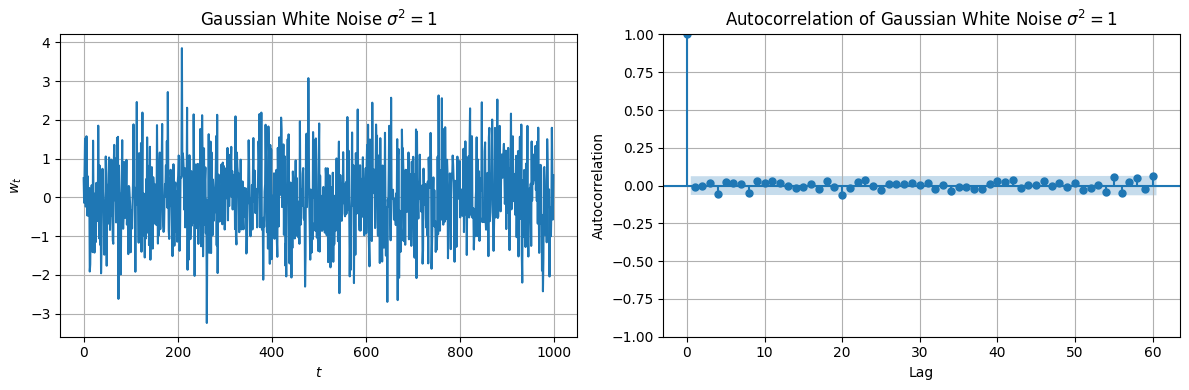

In [6]:
n = 1000
std_devs = [1]
np.random.seed(42)
data = [np.random.normal(loc=0, scale=sd, size=n) for sd in std_devs]
fig, axs = get_figure(nrows=1, ncols=len(std_devs)+1, figsize=(12, 4))

for ax, series, sd in zip(axs, data, std_devs):
    time_plot(
        x=np.arange(n),
        y=series,
        title=f'Gaussian White Noise $\sigma^2={sd}$',
        ylabel='$w_t$',
        ax=ax
    )
ax = axs[-1]
sm.graphics.tsa.plot_acf(data[0], lags=60, ax=ax)
ax.set_title(f'Autocorrelation of Gaussian White Noise $\sigma^2={std_devs[0]}$')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.grid(True)
fig.tight_layout()

### Random walk process

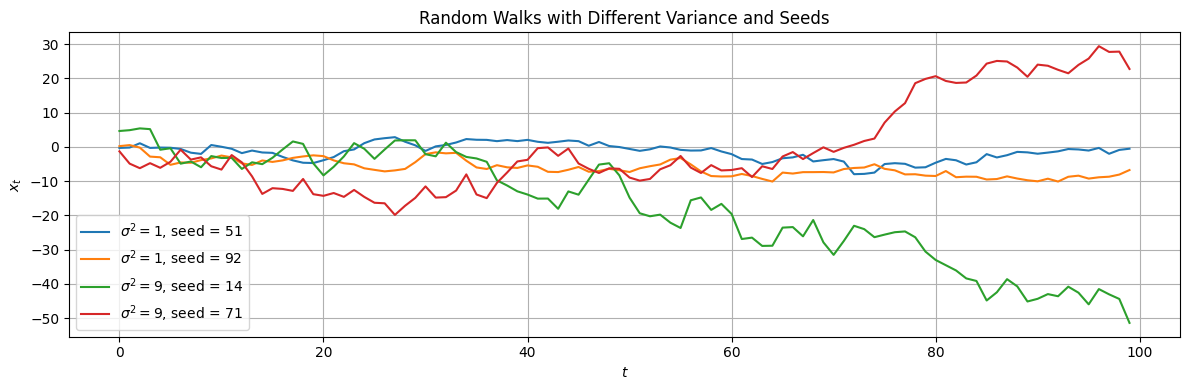

In [7]:
np.random.seed(42)
n_steps = 100
variances = [1, 9]
seeds = np.random.randint(0, 100, (len(variances), 2))

fig, [ax] = get_figure()
for i, var in enumerate(variances):
     for seed in seeds[i]:
        rw = get_random_walk(seed, n_steps, var)
        time_plot(
            x=np.arange(n_steps),
            y=rw,
            label=f'$\sigma^2 = {var}$, seed = {seed}',
            title='Random Walks with Different Variance and Seeds',
            ax=ax
        )
fig.tight_layout()

### Random walk with drift

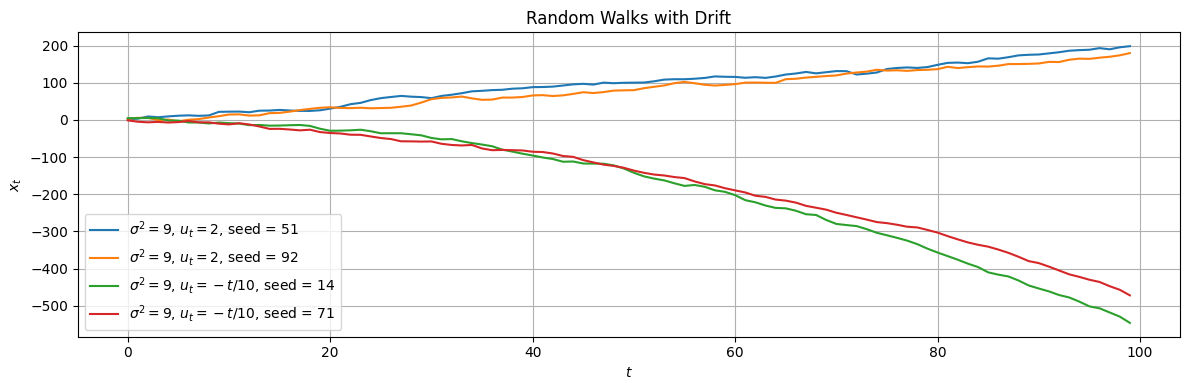

In [8]:
np.random.seed(42)
seeds = np.random.randint(0, 100, (2, 2))
n_steps = 100
drifts = [2, -0.1 * np.arange(n_steps)]

fig, [ax] = get_figure()
formulae = [f"$u_t = {drifts[0]}$", "$u_t = -t/10$"]
for i, (drift, formula) in enumerate(zip(drifts, formulae)):
    for seed in seeds[i]:
        rw = get_random_walk(seed, n_steps, 9, drift)
        time_plot(
            x=np.arange(n_steps),
            y=rw, 
            label=f'$\sigma^2 = 9$, {formula}, seed = {seed}',
            title='Random Walks with Drift',
            ax=ax
        )
fig.tight_layout()

## Seasonal random walk

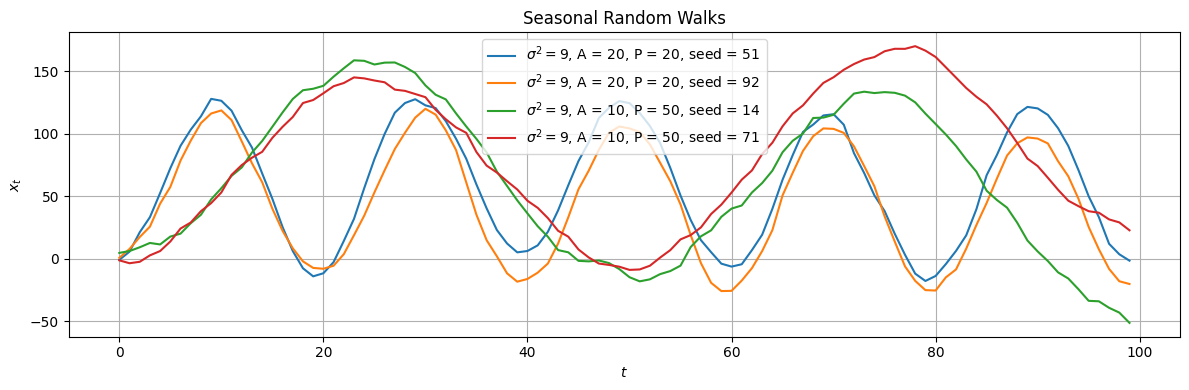

In [9]:
np.random.seed(42)
seeds = np.random.randint(0, 100, (2, 2))
n_steps = 100
amplitudes = [20, 10]
periods = [20, 50]

fig, [ax] = get_figure()
for i, (amp, period) in enumerate(zip(amplitudes, periods)):
    for seed in seeds[i]:
        samples = np.arange(n_steps)
        seasonal = amp * np.sin(2 * np.pi * samples / period)
        rw = get_random_walk(seed, n_steps, 9, seasonal=seasonal)
        time_plot(
            x=np.arange(n_steps),
            y=rw, 
            label=f'$\sigma^2 = 9$, A = {amp}, P = {period}, seed = {seed}',
            title='Seasonal Random Walks',
            ax=ax
        )
fig.tight_layout()

## Seasonal random walk with drift

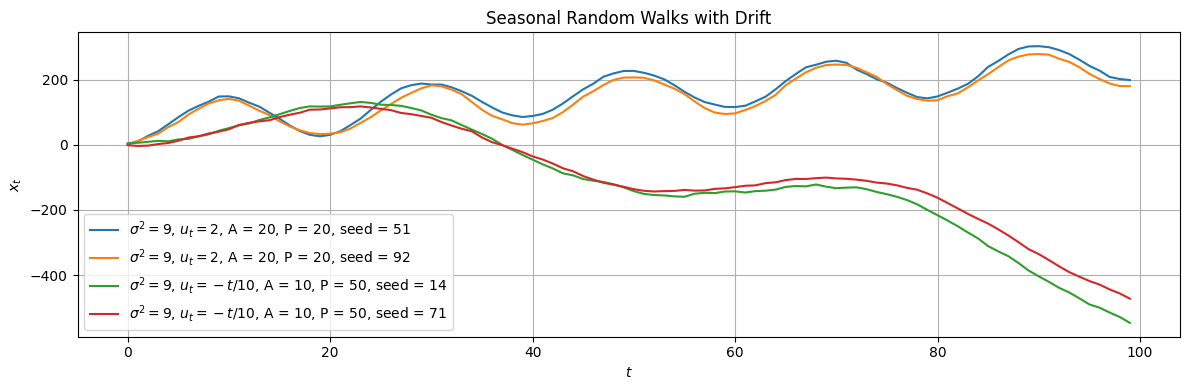

In [10]:
np.random.seed(42)
seeds = np.random.randint(0, 100, (2, 2))
n_steps = 100

amplitudes = [20, 10]
periods = [20, 50]
drifts = [2, -0.1 * np.arange(n_steps)]

fig, [ax] = get_figure()
formulae = [f"$u_t = {drifts[0]}$", "$u_t = -t/10$"]
for i, (amp, period, drift, formula) in enumerate(
        zip(amplitudes, periods, drifts, formulae)
):
    for seed in seeds[i]:
        samples = np.arange(n_steps)
        seasonal = amp * np.sin(2 * np.pi * samples / period)
        rw = get_random_walk(seed, n_steps, 9, drift=drift, seasonal=seasonal)
        time_plot(
            x=np.arange(n_steps),
            y=rw, 
            label=f'$\sigma^2 = 9$, {formula}, A = {amp}, P = {period}, seed = {seed}',
            title='Seasonal Random Walks with Drift',
            ax=ax
        )
fig.tight_layout()

## Decomposed seasonal random walk with drift

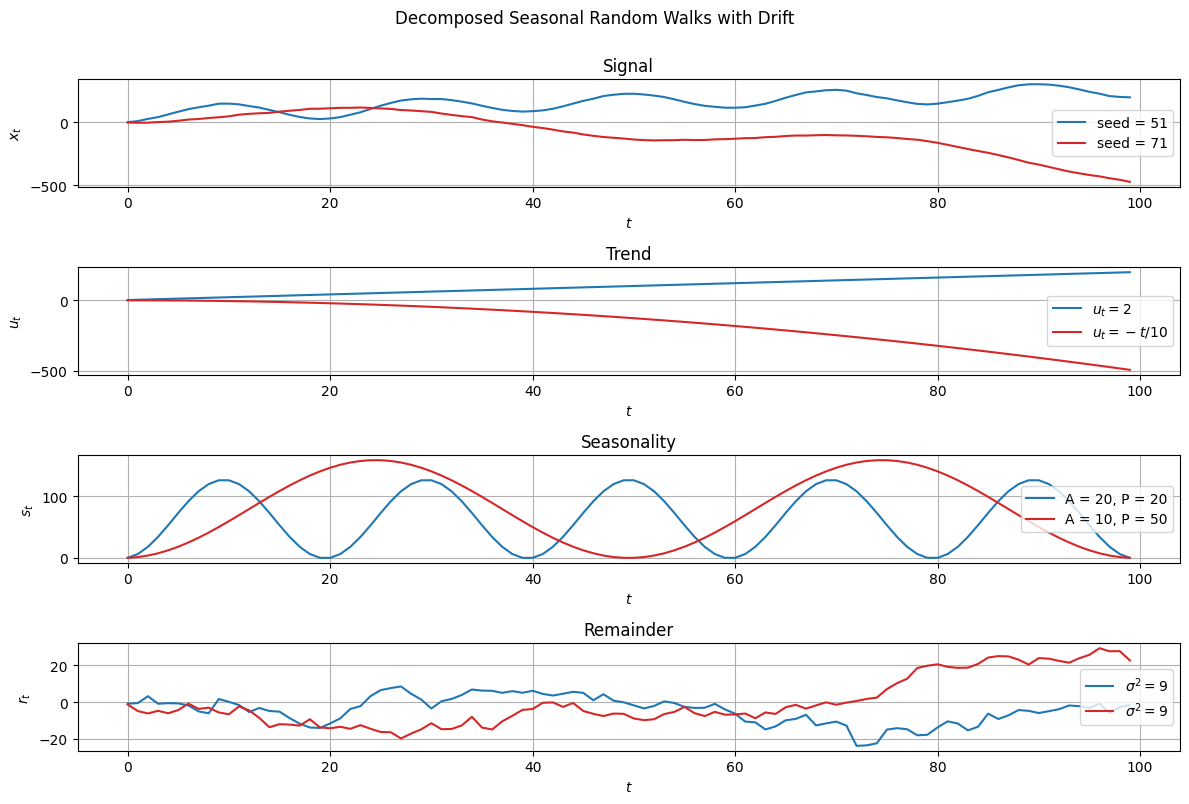

In [11]:
np.random.seed(42)
seeds = np.random.randint(0, 100, (2, 2))
n_steps = 100

amplitudes = [20, 10]
periods = [20, 50]
drifts = [np.repeat(2, n_steps), -0.1 * np.arange(n_steps)]

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axs = get_figure(4, 1, figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs
formulae = [f"$u_t = {drifts[0][0]}$", "$u_t = -t/10$"]
for i, (amp, period, drift, formula, color) in enumerate(zip(amplitudes, periods, drifts, formulae, [color_cycle[0], color_cycle[3]])):
    seed = seeds[i][i]
    np.random.seed(seed)
    samples = np.arange(n_steps)
    seasonal = amp * np.sin(2 * np.pi * samples / period)
    rw = get_random_walk(seed, n_steps, 9, drift=drift, seasonal=seasonal)
    drift = np.cumsum(drift)
    seasonal = np.cumsum(seasonal)
    ax1.plot(rw, label=f'seed = {seed}', color=color)
    ax2.plot(drift, label=formula, color=color)
    ax3.plot(seasonal, label=f'A = {amp}, P = {period}', color=color)
    ax4.plot(rw - drift - seasonal, label='$\sigma^2 = 9$', color=color)

fig.suptitle('Decomposed Seasonal Random Walks with Drift', y=1)
for ax, title, xlab, ylab in zip(
    axs,
    ["Signal", "Trend", "Seasonality", "Remainder"],
    ["$t$"]*4,
    ["$x_t$", "$u_t$", "$s_t$", "$r_t$"],
): 
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.legend(loc="center right")
fig.tight_layout()

## Moving average smoothing

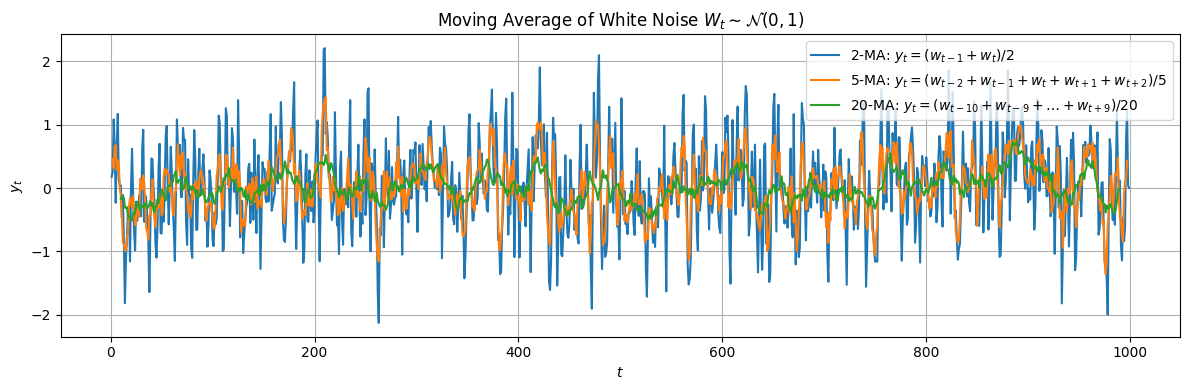

In [12]:
np.random.seed(42)
m_orders = [2, 5, 20]
n_points = 1000
std_dev = 1
white_noise = np.random.normal(loc=0, scale=std_dev, size=n_points)

fig, [ax] = get_figure()
for m in m_orders:
    formula, samples, ma_series = moving_average_smoothing(white_noise, m)
    time_plot(
            x=samples,
            y=ma_series, 
            label=f"{m}-MA: {formula}",
            title='Moving Average of White Noise $W_t \sim \mathcal{N}(0, 1)$',
            ylabel='$y_t$',
            ax=ax
        )
fig.tight_layout()

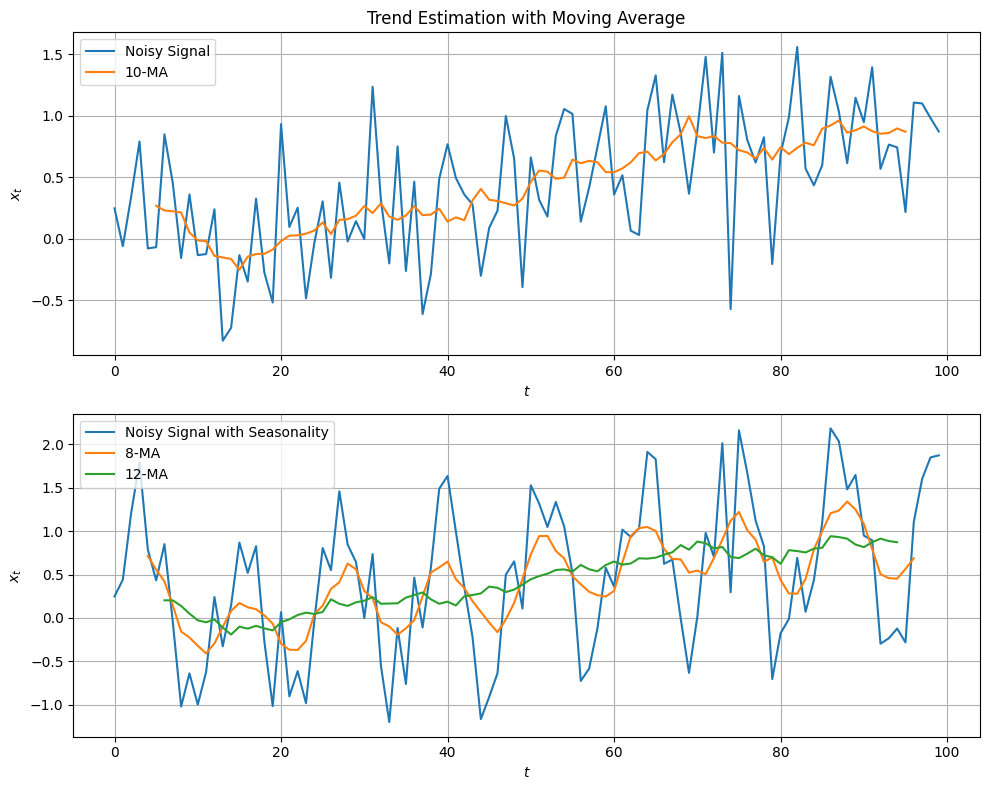

In [13]:
np.random.seed(42)
samples = np.arange(0, 100)
trend = 0.01 * samples
noise = np.random.normal(scale=0.5, size=len(samples))
signal_trend = trend + noise  # Noisy signal

seasonal_period = 12
seasonality = np.sin(2 * np.pi * samples / seasonal_period)
signal_seasonal = trend + seasonality + noise  # Signal with trend, seasonality and noise

fig, [ax1, ax2] = get_figure(2, 1, figsize=(10, 8))
time_plot(
    x=samples,
    y=signal_trend, 
    label="Noisy Signal",
    ax=ax1
)
_, ma_samples, ma = moving_average_smoothing(signal_trend, 10)
time_plot(
    x=ma_samples,
    y=ma, 
    label="10-MA",
    ax=ax1
)

time_plot(
    x=samples,
    y=signal_seasonal, 
    label="Noisy Signal with Seasonality",
    ax=ax2
)
_, ma_samples, ma = moving_average_smoothing(signal_seasonal, 8)
time_plot(
    x=ma_samples,
    y=ma, 
    label="8-MA",
    ax=ax2
)
_, ma_samples, ma = moving_average_smoothing(signal_seasonal, 12)
time_plot(
    x=ma_samples,
    y=ma, 
    label="12-MA",
    ax=ax2
)
ax1.set_title("Trend Estimation with Moving Average")
ax2.set_title("")
fig.tight_layout()

## Classical decomposition

### statsmodels.tsa.seasonal.seasonal_decompose

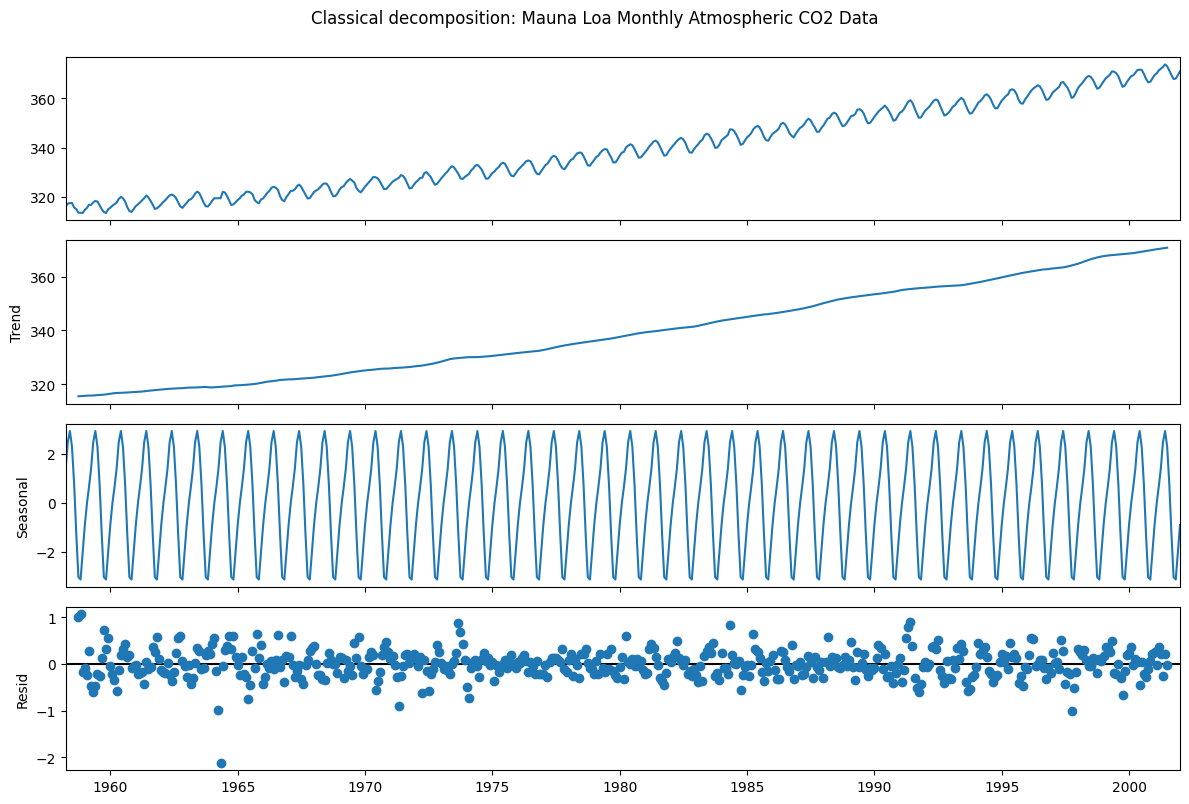

In [14]:
data = get_mauna_loa_co2()
data = data.resample('ME').mean().ffill()
res = seasonal_decompose(data)
fig = res.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Classical decomposition: Mauna Loa Monthly Atmospheric CO2 Data", y=1)
fig.tight_layout()

### Re-implementation

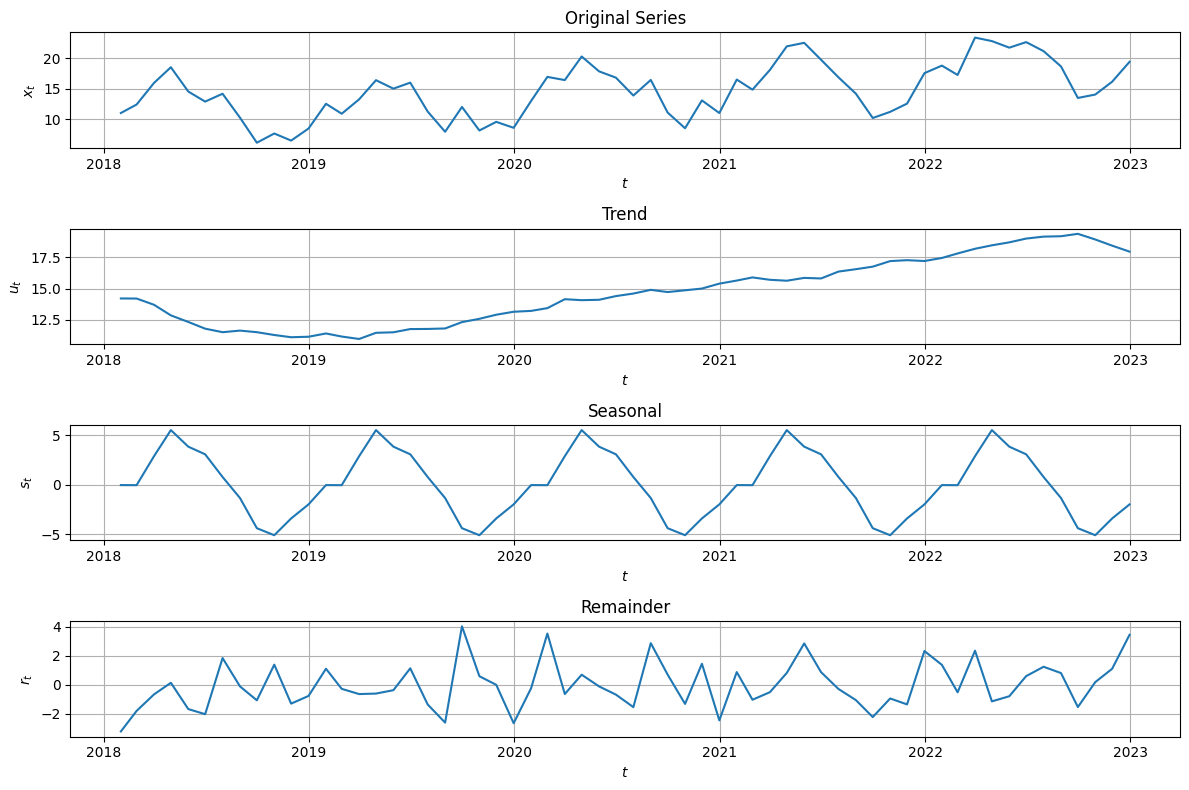

In [15]:
np.random.seed(42)
n_periods = 12
n_years = 5
n_steps = n_periods * n_years

trend = np.linspace(10, 20, n_steps)
seasonality = 5 * np.sin(2 * np.pi * np.arange(n_steps) / n_periods)
noise = np.random.normal(0, 2, n_steps)
signal = trend + seasonality + noise

df = pd.DataFrame({'Sales': signal})
df.index = pd.date_range(start='2018-01-01', periods=n_steps, freq='ME')

# Detrend series
df['Trend'] = df['Sales'].rolling(window=12, center=True, min_periods=1).mean()
df['Detrended'] = df['Sales'] - df['Trend']
# Calculate the seasonal components using period adjusted averages
df['Month'] = df.index.month
seasonal_avg = df.groupby('Month')['Detrended'].mean()
# Adjust seasonal components
seasonal_avg_adjusted = seasonal_avg - seasonal_avg.mean()
# Repeat the seasonal component values for each period
df['Seasonal'] = df['Month'].map(seasonal_avg_adjusted)
# Deseasonalize detrended series
df['Remainder'] = df['Detrended'] - df['Seasonal']

fig, [ax1, ax2, ax3, ax4] = get_figure(4, 1, figsize=(12, 8))
time_plot(
    x=df.index,
    y=df['Sales'], 
    title='Original Series',
    ax=ax1
)
time_plot(
    x=df.index,
    y=df['Trend'], 
    title='Trend',
    ax=ax2,
    ylabel='$u_t$',
)
time_plot(
    x=df.index,
    y=df['Seasonal'], 
    title='Seasonal',
    ax=ax3,
    ylabel='$s_t$',
)
time_plot(
    x=df.index,
    y=df['Remainder'], 
    title='Remainder',
    ax=ax4,
    ylabel='$r_t$',
)
fig.tight_layout()

## STL decomposition

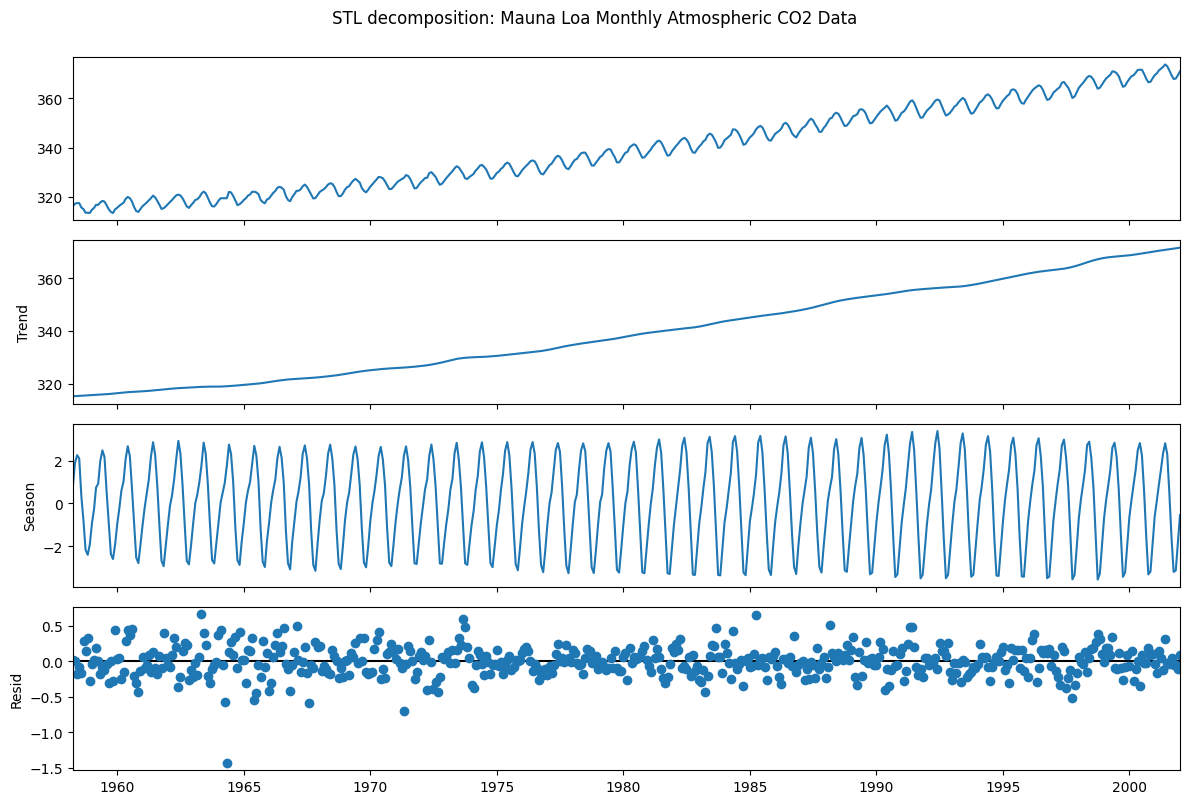

In [16]:
data = get_mauna_loa_co2()
data = data.resample('ME').mean().ffill()
res = STL(data).fit()
fig = res.plot()
fig.axes[0].set_title("")
fig.set_size_inches(12, 8)
fig.suptitle("STL decomposition: Mauna Loa Monthly Atmospheric CO2 Data", y=1)
fig.tight_layout()

## Multiple seasonalities

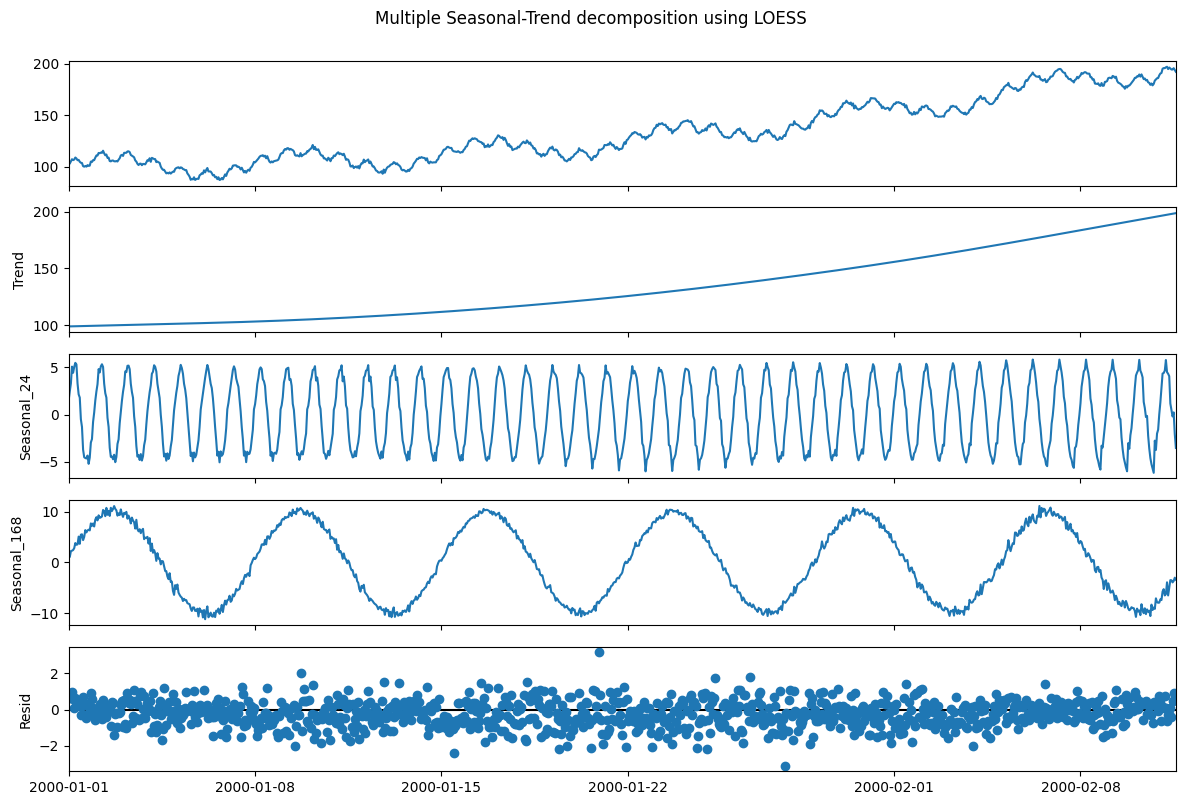

In [17]:
np.random.seed(42)
t = np.arange(1, 1000)
trend = 0.0001 * t ** 2 + 100
daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))
noise = np.random.randn(len(t))
y = trend + daily_seasonality + weekly_seasonality + noise
index = pd.date_range(start='2000-01-01', periods=len(t), freq='h')
data = pd.DataFrame(data=y, index=index)
res = MSTL(data, periods=(24, 24*7)).fit()
fig = res.plot()
fig.axes[0].set_title("")
fig.set_size_inches(12, 8)
fig.suptitle("Multiple Seasonal-Trend decomposition using LOESS", y=1)
fig.tight_layout()